In [1]:
import warnings
warnings.simplefilter('ignore')

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Viz kernels

**Se cargan el modelo**

In [4]:
from keras.models import load_model
model = load_model('data/dogs-vs-cats/h5_small_models/cats_and_dogs_small_2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## Procesando una sola imagen

In [5]:
img_path='data/dogs-vs-cats/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image 
import numpy as np


img = image.load_img(img_path, target_size=(150, 150)) 

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


**Plot imagen**

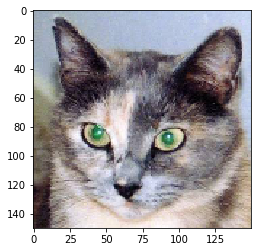

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.imshow(img_tensor[0])
plt.show();

**se inicializa un modelo**

In [7]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] 
activation_model = models.Model(inputs=model.input, 
                                outputs=layer_outputs)


activations = activation_model.predict(img_tensor)

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


**se visualiza el 4º canal**

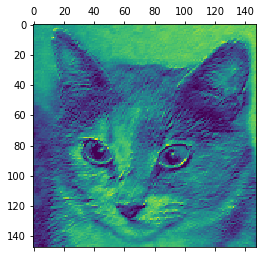

In [14]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis');

**se visualiza el 7º canal**

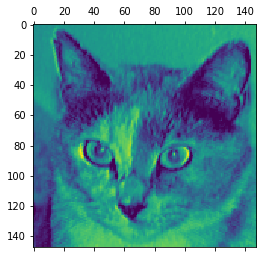

In [15]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis');

**se visualiza el 2º canal**

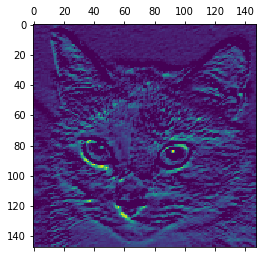

In [16]:
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis');

## Todos canales (cada activacion intermedia)

In [17]:
layer_names = []

for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
    
images_per_row = 16

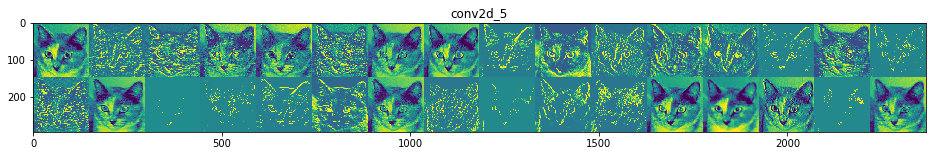

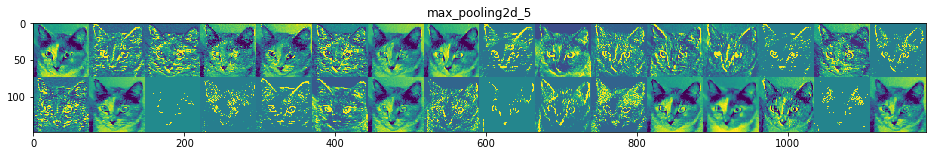

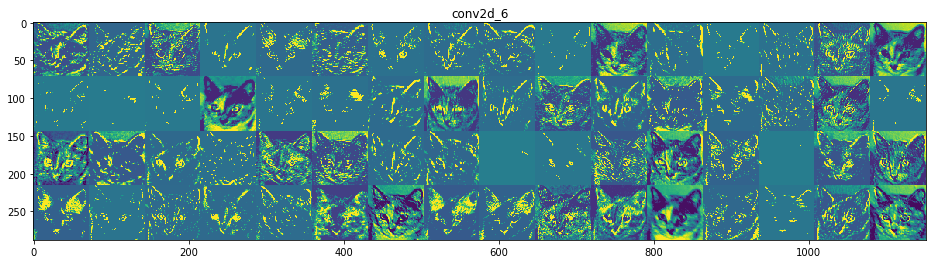

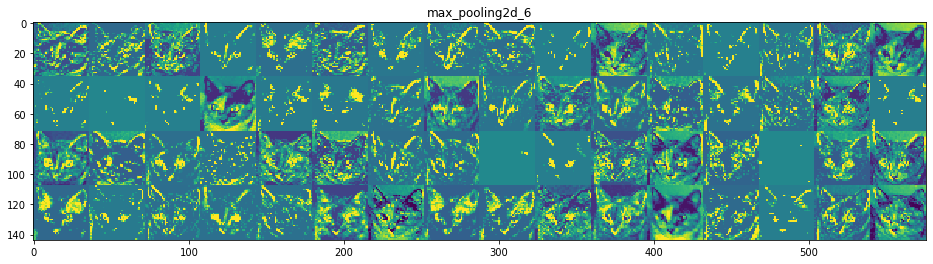

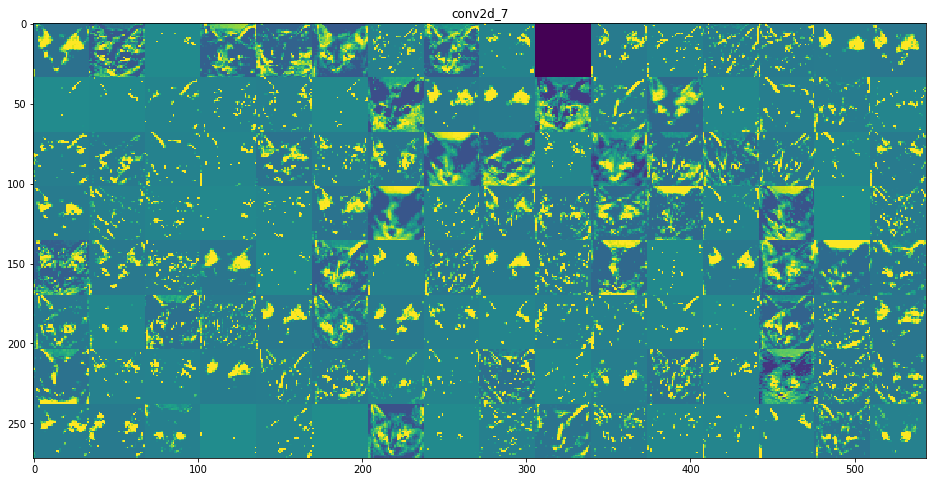

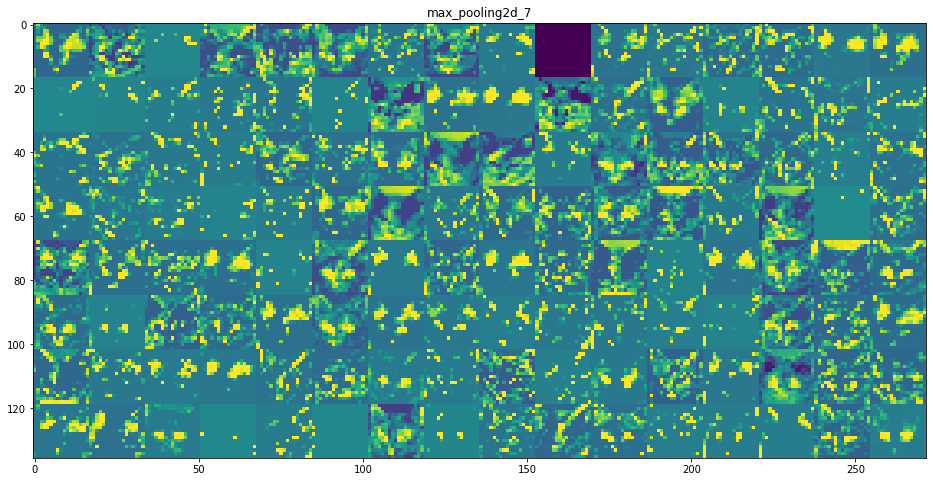

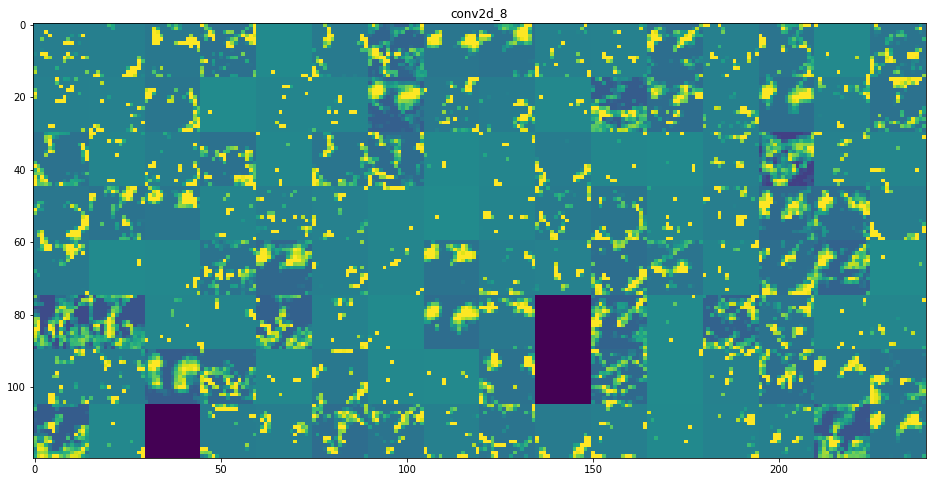

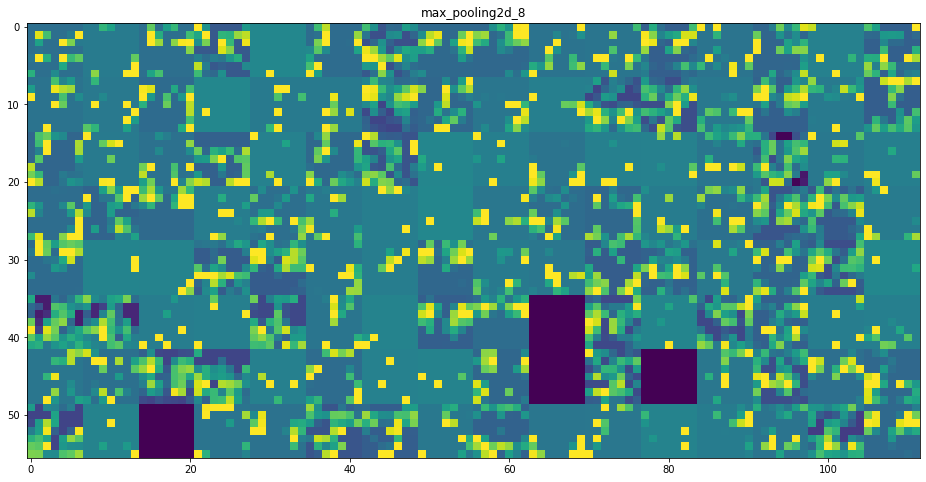

In [18]:
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,
                                             col * images_per_row + row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis');      
    

# Visualizando Filtros

In [19]:
# se define un tensor

from keras.applications import VGG16
from keras import backend as K


model = VGG16(weights='imagenet',
              include_top=False)


layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output


loss = K.mean(layer_output[:, :, :, filter_index])

In [21]:
# y su gradiente

grads = K.gradients(loss, model.input)[0]

grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # normalizacion

**evaluando**

In [22]:
iterate = K.function([model.input], [loss, grads])


import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

**maximizacion via SGD**

In [23]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.


step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

**se convierte a imagen**

In [31]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [32]:
def generate_pattern(layer_name, filter_index, size=150):
    
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    
    return deprocess_image(img)


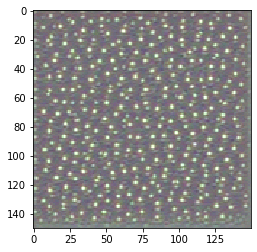

In [33]:
plt.imshow(generate_pattern('block3_conv1', 0));

## Malla de todos los filtros

In [34]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

In [42]:
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, 
                                      i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img

In [44]:
results=results.astype('uint8')

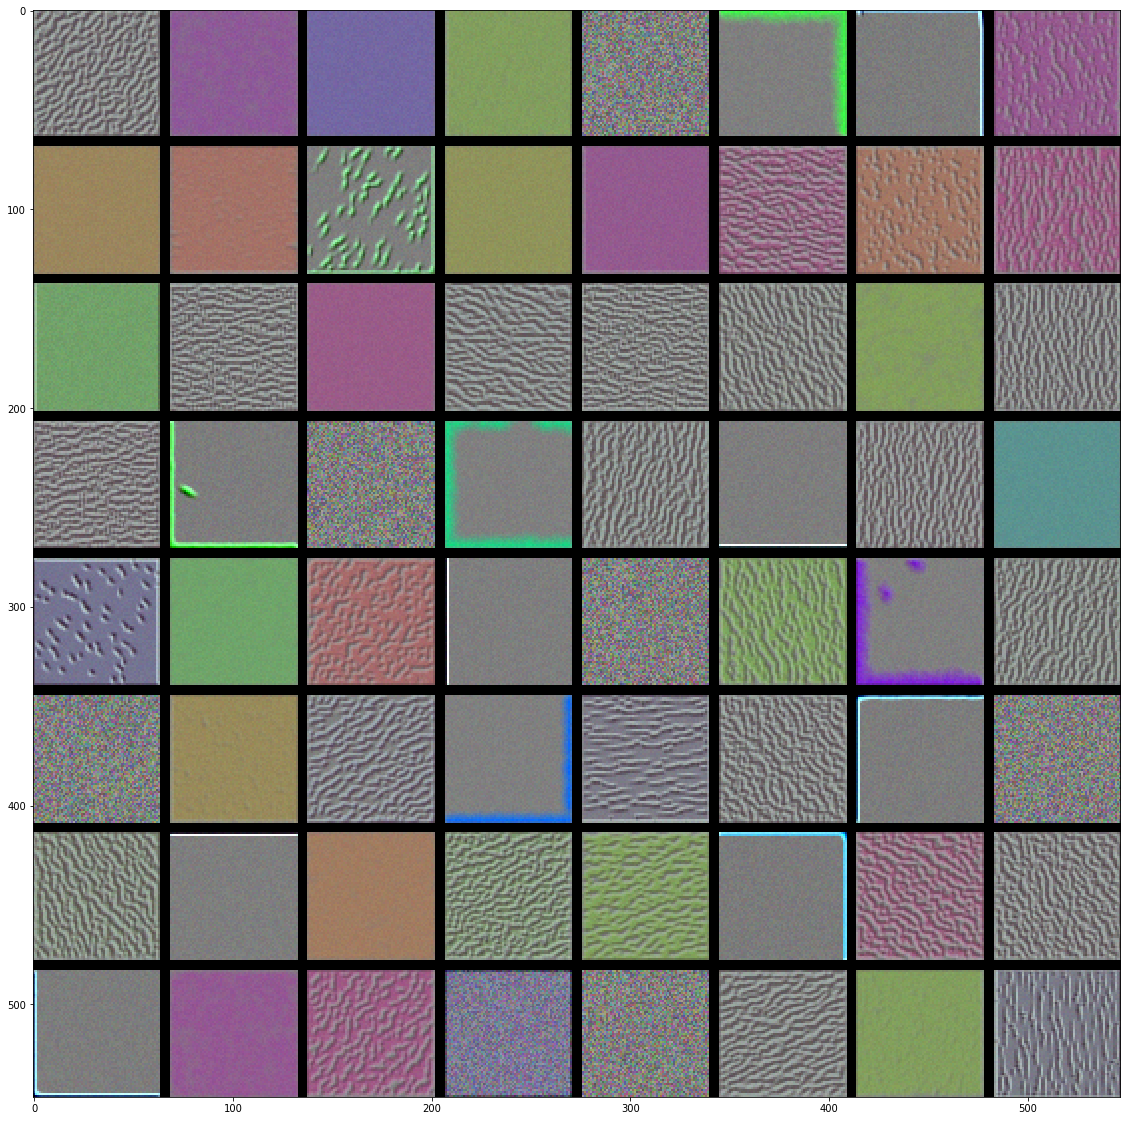

In [46]:
layer_name = 'block1_conv1'

plt.figure(figsize=(20, 20))
plt.imshow(results);

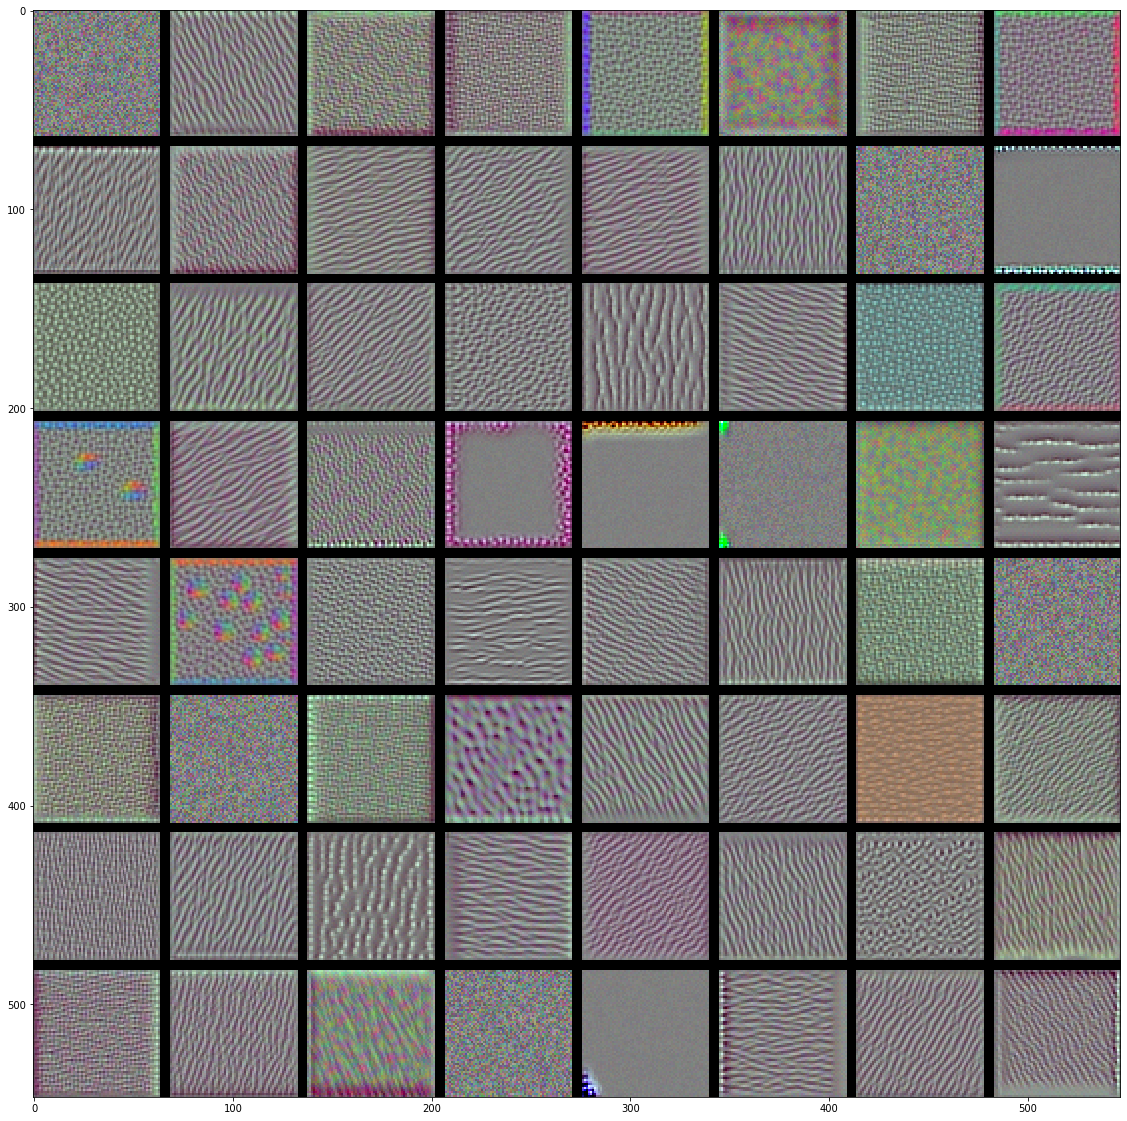

In [50]:
layer_name = 'block2_conv1'

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, 
                                      i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img
        
        
results=results.astype('uint8')


plt.figure(figsize=(20, 20))
plt.imshow(results);

In [ ]:
layer_name = 'block3_conv1'

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, 
                                      i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img
        
        
results=results.astype('uint8')


plt.figure(figsize=(20, 20))
plt.imshow(results);

In [ ]:
layer_name = 'block4_conv1'

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, 
                                      i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img
        
        
results=results.astype('uint8')


plt.figure(figsize=(20, 20))
plt.imshow(results);